# Structured and time series data

This notebook contains an implementation of the third place result in the Rossman Kaggle competition as detailed in Guo/Berkhahn's [Entity Embeddings of Categorical Variables](https://arxiv.org/abs/1604.06737).

The motivation behind exploring this architecture is it's relevance to real-world application. Most data used for decision making day-to-day in industry is structured and/or time-series data. Here we explore the end-to-end process of using neural networks with practical structured data problems.

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.structured import *
from fastai.column_data import *
np.set_printoptions(threshold=50, edgeitems=20)

PATH='data/rossman/'

In [3]:
ls {PATH} -lash

total 634M
4.0K drwxrwxrwx 1 bmn bmn 4.0K Mar 24 13:00 ./
8.0K drwxrwxrwx 1 bmn bmn 8.0K Mar 28 21:34 ../
4.4M -rwxrwxrwx 1 bmn bmn 4.4M Mar 24 13:17 df*
 88K -rwxrwxrwx 1 bmn bmn  85K Jan 11  2017 googletrend.csv*
556M -rwxrwxrwx 1 bmn bmn 556M Mar 24 13:20 joined*
 27M -rwxrwxrwx 1 bmn bmn  27M Mar 24 13:20 joined_test*
   0 drwxrwxrwx 1 bmn bmn    0 Feb  3 19:20 models/
7.4M -rwxrwxrwx 1 bmn bmn 7.4M Dec  4 00:24 rossmann.tgz*
312K -rwxrwxrwx 1 bmn bmn 311K Sep 30  2015 sample_submission.csv*
 512 -rwxrwxrwx 1 bmn bmn  265 Jan 11  2017 state_names.csv*
 44K -rwxrwxrwx 1 bmn bmn  44K Sep 30  2015 store.csv*
 12K -rwxrwxrwx 1 bmn bmn 8.9K Jan  7  2017 store_states.csv*
1.4M -rwxrwxrwx 1 bmn bmn 1.4M Sep 30  2015 test.csv*
   0 drwxrwxrwx 1 bmn bmn    0 Mar 19 00:42 tmp/
 37M -rwxrwxrwx 1 bmn bmn  37M Sep 30  2015 train.csv*
1.5M -rwxrwxrwx 1 bmn bmn 1.5M Jan 11  2017 weather.csv*


We now need to load our set of engineered features.

The steps required to get datasets in such a state are outlined in [this fast.ai notebook](https://github.com/fastai/fastai/blob/master/courses/dl1/lesson3-rossman.ipynb). The steps were explicitly outlined in the paper, and are all fairly typical feature engineering steps for dealing with time series data and are practical in any similar setting, so I encourage you to make the time to look at them.

## Create features

In [4]:
joined = pd.read_feather(f'{PATH}joined')
joined_test = pd.read_feather(f'{PATH}joined_test')

In [5]:
joined.head().T.head(40)

,0,1,2,3,4
level_0,0,1,2,3,4
index,0,1,2,3,4
Store,1,2,3,4,5
DayOfWeek,5,5,5,5,5
Date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
Sales,5263,6064,8314,13995,4822
Customers,555,625,821,1498,559
Open,1,1,1,1,1
Promo,1,1,1,1,1
StateHoliday,False,False,False,False,False


Now that we've engineered all our features, we need to convert to input compatible with a neural network.

This includes converting categorical variables into contiguous integers or one-hot encodings, normalizing continuous features to standard normal, etc...

In [6]:
cat_vars = ['Store', 'DayOfWeek', 'Year', 'Month', 'Day', 'StateHoliday', 'CompetitionMonthsOpen',
    'Promo2Weeks', 'StoreType', 'Assortment', 'PromoInterval', 'CompetitionOpenSinceYear', 'Promo2SinceYear',
    'State', 'Week', 'Events', 'Promo_fw', 'Promo_bw', 'StateHoliday_fw', 'StateHoliday_bw',
    'SchoolHoliday_fw', 'SchoolHoliday_bw']

contin_vars = ['CompetitionDistance', 'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
   'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Wind_SpeedKm_h', 
   'Mean_Wind_SpeedKm_h', 'CloudCover', 'trend', 'trend_DE',
   'AfterStateHoliday', 'BeforeStateHoliday', 'Promo', 'SchoolHoliday']

n = len(joined); n

844338

In [7]:
dep = 'Sales'
joined = joined[cat_vars+contin_vars+[dep, 'Date']].copy()

In [8]:
joined_test[dep] = 0
joined_test = joined_test[cat_vars+contin_vars+[dep, 'Date', 'Id']].copy()

In [9]:
for v in cat_vars: joined[v] = joined[v].astype('category').cat.as_ordered()

In [10]:
apply_cats(joined_test, joined)

In [11]:
for v in contin_vars:
    joined[v] = joined[v].astype('float32')
    joined_test[v] = joined_test[v].astype('float32')

We're going to run on a sample.

In [12]:
idxs = get_cv_idxs(n, val_pct=150000/n)
joined_samp = joined.iloc[idxs].set_index("Date")
samp_size = len(joined_samp); samp_size

150000

To run on the full dataset, use this instead:

In [84]:
samp_size = n
joined_samp = joined.set_index("Date")

We can now process our data...

In [13]:
joined_samp.head(2)

,Store,DayOfWeek,Year,Month,Day,StateHoliday,CompetitionMonthsOpen,Promo2Weeks,StoreType,Assortment,...,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,CloudCover,trend,trend_DE,AfterStateHoliday,BeforeStateHoliday,Promo,SchoolHoliday,Sales
Date,,,,,,,,,,,,,,,,,,,,,
2015-06-16,257,2,2015,6,16,False,24,0,a,a,...,18.0,8.0,6.0,63.0,71.0,22.0,0.0,1.0,0.0,5934
2013-10-30,4,3,2013,10,30,False,24,0,c,c,...,29.0,16.0,2.0,74.0,66.0,27.0,-56.0,0.0,0.0,7800


In [14]:
df, y, nas, mapper = proc_df(joined_samp, 'Sales', do_scale=True)
yl = np.log(y)

In [20]:
??proc_df

In [15]:
joined_test = joined_test.set_index("Date")

In [16]:
df_test, _, nas, mapper = proc_df(joined_test, 'Sales', do_scale=True, skip_flds=['Id'],
                                  mapper=mapper, na_dict=nas)

In [17]:
df.head(2)

,Store,DayOfWeek,Year,Month,Day,StateHoliday,CompetitionMonthsOpen,Promo2Weeks,StoreType,Assortment,...,Mean_Wind_SpeedKm_h,CloudCover,trend,trend_DE,AfterStateHoliday,BeforeStateHoliday,Promo,SchoolHoliday,CompetitionDistance_na,CloudCover_na
Date,,,,,,,,,,,,,,,,,,,,,
2015-06-16,257,2,3,6,16,1,25,1,1,1,...,-0.651394,0.266629,-0.194358,0.487305,-0.525077,1.109608,1.115768,-0.489079,-0.050661,-0.294389
2013-10-30,4,3,1,10,30,1,25,1,3,3,...,0.700532,-2.197401,0.769911,-0.026011,-0.363976,-0.602128,-0.896244,-0.489079,-0.050661,-0.294389


In time series data, cross-validation is not random. Instead, our holdout data is generally the most recent data, as it would be in real application. This issue is discussed in detail in [this post](http://www.fast.ai/2017/11/13/validation-sets/) on the fast.ai web site.

One approach is to take the last 25% of rows (sorted by date) as our validation set.

In [18]:
train_ratio = 0.75
# train_ratio = 0.9
train_size = int(samp_size * train_ratio); train_size
val_idx = list(range(train_size, len(df)))

An even better option for picking a validation set is using the exact same length of time period as the test set uses - this is implemented here:

In [19]:
val_idx = np.flatnonzero(
    (df.index<=datetime.datetime(2014,9,17)) & (df.index>=datetime.datetime(2014,8,1)))

In [19]:
val_idx

array([    24,     31,     37,     47,     81,     87,    102,    104,    125,    136,    159,    189,
          190,    235,    265,    281,    317,    356,    357,    375, ..., 149583, 149612, 149653, 149674,
       149681, 149686, 149712, 149718, 149755, 149769, 149818, 149822, 149824, 149826, 149831, 149841,
       149867, 149932, 149950, 149976])

## DL

We're ready to put together our models.

Root-mean-squared percent error is the metric Kaggle used for this competition.

In [20]:
def inv_y(a): return np.exp(a)

def exp_rmspe(y_pred, targ):
    targ = inv_y(targ)
    pct_var = (targ - inv_y(y_pred))/targ
    return math.sqrt((pct_var**2).mean())

max_log_y = np.max(yl)
y_range = (0, max_log_y*1.2)

We can create a ModelData object directly from our data frame.

In [21]:
md = ColumnarModelData.from_data_frame(PATH, val_idx, df, yl.astype(np.float32), cat_flds=cat_vars, bs=128,
                                       test_df=df_test)

Some categorical variables have a lot more levels than others. Store, in particular, has over a thousand!

In [22]:
cat_sz = [(c, len(joined_samp[c].cat.categories)+1) for c in cat_vars]

In [23]:
cat_sz

[('Store', 1116),
 ('DayOfWeek', 8),
 ('Year', 4),
 ('Month', 13),
 ('Day', 32),
 ('StateHoliday', 3),
 ('CompetitionMonthsOpen', 26),
 ('Promo2Weeks', 27),
 ('StoreType', 5),
 ('Assortment', 4),
 ('PromoInterval', 4),
 ('CompetitionOpenSinceYear', 24),
 ('Promo2SinceYear', 9),
 ('State', 13),
 ('Week', 53),
 ('Events', 22),
 ('Promo_fw', 7),
 ('Promo_bw', 7),
 ('StateHoliday_fw', 4),
 ('StateHoliday_bw', 4),
 ('SchoolHoliday_fw', 9),
 ('SchoolHoliday_bw', 9)]

We use the *cardinality* of each variable (that is, its number of unique values) to decide how large to make its *embeddings*. Each level will be associated with a vector with length defined as below. The maximum value `50` here is arbitrary, based on empirical research by the small number of people who have published on this, and this is because it is as-yet unknown what the relationship is between the size of the embeddings and their ability to capture the causal structure of the categorical variables they encode. Also because the datasets in question determine the causal nature of the problems. This is a problem open to interested researchers.

In [24]:
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]

In [25]:
emb_szs

[(1116, 50),
 (8, 4),
 (4, 2),
 (13, 7),
 (32, 16),
 (3, 2),
 (26, 13),
 (27, 14),
 (5, 3),
 (4, 2),
 (4, 2),
 (24, 12),
 (9, 5),
 (13, 7),
 (53, 27),
 (22, 11),
 (7, 4),
 (7, 4),
 (4, 2),
 (4, 2),
 (9, 5),
 (9, 5)]

In [26]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                   0.04, 1, [1000,500], [0.001,0.01], y_range=y_range)
lr = 1e-3

Here, we will use fastai's learning rate finder. It uses a technique from Leslie N. Smith's paper ["_Cyclical Learning Rates for Training Neural Networks_"](https://arxiv.org/abs/1506.01186). In it, he describes various techniques for tuning the most important variable for training neural networks: the **learning rate**. The learning rate finder is a method for finding the optimal learning rate to use. In short, it lets us use small batches of our own data to find it! With this method, we don't need to run many epochs, or increase the learning rate step-by-step, empirically. It saves us **a lot** of time.

In [28]:
m.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 61%|██████    | 678/1120 [00:09<00:06, 68.63it/s, loss=0.323] 


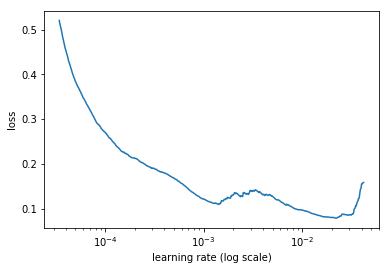

In [29]:
m.sched.plot(100)

### Sample

In [201]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                   0.04, 1, [1000,500], [0.001,0.01], y_range=y_range)
lr = 1e-3

In [31]:
m.fit(lr, 3, metrics=[exp_rmspe])

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

  0%|          | 5/1120 [00:00<02:07,  8.71it/s, loss=4.81]

Exception in thread Thread-4:
Traceback (most recent call last):
  File "/home/bmn/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/bmn/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/bmn/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   exp_rmspe                      
    0      0.027826   0.023613   0.148057  
    1      0.019643   0.02124    0.134956                       
    2      0.016942   0.02074    0.133171                       



[0.02073983, 0.1331709599483122]

In [30]:
m.fit(lr, 5, metrics=[exp_rmspe], cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

epoch      trn_loss   val_loss   exp_rmspe                      
    0      0.034787   0.041617   0.189426  
    1      0.021808   0.026753   0.151862                       
    2      0.016506   0.02438    0.142282                       
    3      0.013813   0.022749   0.137383                       
    4      0.01296    0.021005   0.132944                       



[0.021004925, 0.13294398266097165]

In [31]:
m.fit(lr, 2, metrics=[exp_rmspe], cycle_len=4, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=12), HTML(value='')))

epoch      trn_loss   val_loss   exp_rmspe                      
    0      0.016107   0.020895   0.135822  
    1      0.012619   0.019241   0.128867                       
    2      0.010069   0.016868   0.120256                        
    3      0.008526   0.016966   0.120476                        
    4      0.01304    0.020358   0.1304                         
    5      0.011415   0.016614   0.12087                        
    6      0.010554   0.028748   0.150727                        
    7      0.009381   0.014075   0.11656                         
    8      0.008041   0.017167   0.121704                        
    9      0.006705   0.016083   0.118394                        
    10     0.005873   0.014766   0.115367                        
    11     0.005767   0.014672   0.115211                        



[0.014671917, 0.11521120680332445]

In [52]:
# length of embs is the same as the number of categorical variables
print(len(cat_vars))
m.model

22


MixedInputModel(
  (embs): ModuleList(
    (0): Embedding(1116, 50)
    (1): Embedding(8, 4)
    (2): Embedding(4, 2)
    (3): Embedding(13, 7)
    (4): Embedding(32, 16)
    (5): Embedding(3, 2)
    (6): Embedding(26, 13)
    (7): Embedding(27, 14)
    (8): Embedding(5, 3)
    (9): Embedding(4, 2)
    (10): Embedding(4, 2)
    (11): Embedding(24, 12)
    (12): Embedding(9, 5)
    (13): Embedding(13, 7)
    (14): Embedding(53, 27)
    (15): Embedding(22, 11)
    (16): Embedding(7, 4)
    (17): Embedding(7, 4)
    (18): Embedding(4, 2)
    (19): Embedding(4, 2)
    (20): Embedding(9, 5)
    (21): Embedding(9, 5)
  )
  (lins): ModuleList(
    (0): Linear(in_features=217, out_features=1000, bias=True)
    (1): Linear(in_features=1000, out_features=500, bias=True)
  )
  (bns): ModuleList(
    (0): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True)
    (1): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True)
  )
  (outp): Linear(in_features=500, out_features=1, bias=True)
  (emb_dro

In [49]:
cat_vars[0]

'Store'

In [50]:
# Dimensions of the first embedding matrix match the size of the 'Store' variable in the emb_szs list
m.model.embs[0].state_dict()

OrderedDict([('weight', 
              -3.1246e-02 -1.0305e-02 -3.2985e-02  ...  -1.2616e-04  2.4675e-02  3.8838e-02
              -1.0836e-01  2.6960e-02 -8.7092e-02  ...   1.9851e-01 -1.3562e-01 -5.3408e-02
              -2.6284e-02 -1.8068e-02  3.7349e-02  ...   4.6785e-02 -1.0742e-01 -4.5184e-02
                              ...                   ⋱                   ...                
               4.6649e-02 -1.6469e-03 -2.4291e-02  ...   1.1038e-01  9.3815e-03 -9.5187e-03
               2.4705e-01  1.8132e-01  9.3238e-02  ...  -9.3311e-02  2.1921e-01  1.7345e-01
               5.9206e-03  4.7352e-02 -6.3243e-02  ...   2.7394e-02  3.2803e-02  7.2638e-02
              [torch.cuda.FloatTensor of size 1116x50 (GPU 0)])])

In [53]:
m.model.embs[0].embedding_dim

50

In [54]:
class MixedInputModelX(nn.Module):
    """Class representing a structured dataset with continuous + categorical inputs (hence mixed)
    Arguments:
        emb_szs: List. A list of tuples mapping the cardinality of each categorical variable, with the size of its embedding matrix.
        n_cont: number of continuous variables.
        emb_drop: Float. dropout applied uniformly to all embedding matrices.
        out_sz: Integer. Size of the output layer
        szs: List. size of fully connected layers
        drops: List. dropout values to use for each of the fully connected layers
        y_range: Tuple. a tuple representing the minimum and maximum values of the dependent variable
        use_bn: Bool. Whether or not to use batch normalization
    """
    def __init__(self, emb_szs, n_cont, emb_drop, out_sz, szs, drops,
                 y_range=None, use_bn=False):
        super().__init__()
        self.embs = nn.ModuleList([nn.Embedding(c, s) for c,s in emb_szs])
        for emb in self.embs: emb_init(emb)
        # add all of the embedding matrix dimensions
        n_emb = sum(e.embedding_dim for e in self.embs)
        self.n_emb, self.n_cont=n_emb, n_cont
        # sum of continuous+categorical variable dimensions and fully-connected layer dimensions
        szs = [n_emb+n_cont] + szs
        self.lins = nn.ModuleList([
            nn.Linear(szs[i], szs[i+1]) for i in range(len(szs)-1)])
        self.bns = nn.ModuleList([
            nn.BatchNorm1d(sz) for sz in szs[1:]])
        for o in self.lins: kaiming_normal(o.weight.data)
        self.outp = nn.Linear(szs[-1], out_sz)
        kaiming_normal(self.outp.weight.data)

        self.emb_drop = nn.Dropout(emb_drop)
        self.drops = nn.ModuleList([nn.Dropout(drop) for drop in drops])
        self.bn = nn.BatchNorm1d(n_cont)
        self.use_bn,self.y_range = use_bn,y_range

    def forward(self, x_cat, x_cont):
        """Forward pass through the neural net, for a single batch.
        Accepts 2 input variables, and outputs a Variable of output data
        """
        if self.n_emb != 0:
            x = [e(x_cat[:,i]) for i,e in enumerate(self.embs)]
            x = torch.cat(x, 1)
            x = self.emb_drop(x)
        if self.n_cont != 0:
            x2 = self.bn(x_cont)
            x = torch.cat([x, x2], 1) if self.n_emb != 0 else x2
        for l,d,b in zip(self.lins, self.drops, self.bns):
            x = F.relu(l(x))
            if self.use_bn: x = b(x)
            x = d(x)
        x = self.outp(x)
        if self.y_range:
            x = F.sigmoid(x)
            x = x*(self.y_range[1] - self.y_range[0])
            x = x+self.y_range[0]
        return x

In [55]:
class ColumnarModelDataX(ColumnarModelData):
    def get_learner(self, emb_szs, n_cont, emb_drop, out_sz, szs, drops,
                    y_range=None, use_bn=False, **kwargs):
        model = MixedInputModelX(emb_szs, n_cont, emb_drop, out_sz, szs, drops, y_range, use_bn)
        return StructuredLearner(self, StructuredModel(to_gpu(model)), opt_fn=optim.Adam, **kwargs)

In [56]:
md = ColumnarModelDataX.from_data_frame(PATH, val_idx, df, yl.astype(np.float32), cat_flds=cat_vars, bs=128,
                                        test_df=df_test)

In [58]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                   0.04, 1, [1000,500], [0.001,0.01], y_range=y_range)
lr = 1e-3

In [59]:
m.model

MixedInputModelX(
  (embs): ModuleList(
    (0): Embedding(1116, 50)
    (1): Embedding(8, 4)
    (2): Embedding(4, 2)
    (3): Embedding(13, 7)
    (4): Embedding(32, 16)
    (5): Embedding(3, 2)
    (6): Embedding(26, 13)
    (7): Embedding(27, 14)
    (8): Embedding(5, 3)
    (9): Embedding(4, 2)
    (10): Embedding(4, 2)
    (11): Embedding(24, 12)
    (12): Embedding(9, 5)
    (13): Embedding(13, 7)
    (14): Embedding(53, 27)
    (15): Embedding(22, 11)
    (16): Embedding(7, 4)
    (17): Embedding(7, 4)
    (18): Embedding(4, 2)
    (19): Embedding(4, 2)
    (20): Embedding(9, 5)
    (21): Embedding(9, 5)
  )
  (lins): ModuleList(
    (0): Linear(in_features=217, out_features=1000, bias=True)
    (1): Linear(in_features=1000, out_features=500, bias=True)
  )
  (bns): ModuleList(
    (0): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True)
    (1): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True)
  )
  (outp): Linear(in_features=500, out_features=1, bias=True)
  (emb_dr

### All

In [94]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                   0.04, 1, [1000,500], [0.001,0.01], y_range=y_range)
lr = 1e-3

In [95]:
m.fit(lr, 1, metrics=[exp_rmspe])

A Jupyter Widget

[ 0.       0.01456  0.01544  0.1148 ]                            



In [93]:
m.fit(lr, 3, metrics=[exp_rmspe])

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

[ 0.       0.01418  0.02066  0.12765]                           
[ 1.       0.01081  0.01276  0.11221]                           
[ 2.       0.00976  0.01233  0.10987]                            



In [94]:
m.fit(lr, 3, metrics=[exp_rmspe], cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

[ 0.       0.00801  0.01081  0.09899]                            
[ 1.       0.00714  0.01083  0.09846]                            
[ 2.       0.00707  0.01088  0.09878]                            



### Test

In [185]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                   0.04, 1, [1000,500], [0.001,0.01], y_range=y_range)
lr = 1e-3

In [102]:
m.fit(lr, 3, metrics=[exp_rmspe])

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

[ 0.       0.01413  0.0063   0.07628]                           
[ 1.       0.01022  0.00859  0.08851]                           
[ 2.       0.00932  0.00001  0.00243]                            



In [103]:
m.fit(lr, 3, metrics=[exp_rmspe], cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

[ 0.       0.00748  0.       0.00167]                            
[ 1.       0.00717  0.00009  0.00947]                            
[ 2.       0.00643  0.00013  0.01147]                            



In [105]:
m.save('val0')

In [ ]:
m.load('val0')

In [187]:
x,y=m.predict_with_targs()

In [188]:
exp_rmspe(x,y)

0.01147316926177568

In [189]:
pred_test=m.predict(True)

In [190]:
pred_test = np.exp(pred_test)

In [192]:
joined_test['Sales']=pred_test

In [193]:
csv_fn=f'{PATH}tmp/sub.csv'

In [200]:
joined_test[['Id','Sales']].to_csv(csv_fn, index=False)

In [202]:
FileLink(csv_fn)

/home/ubuntu/fastai/courses/dl1/data/rossmann/tmp/sub.csv

## RF

In [101]:
from sklearn.ensemble import RandomForestRegressor

In [102]:
((val,trn), (y_val,y_trn)) = split_by_idx(val_idx, df.values, yl)

In [103]:
m = RandomForestRegressor(n_estimators=40, max_features=0.99, min_samples_leaf=2,
                          n_jobs=-1, oob_score=True)
m.fit(trn, y_trn);

In [104]:
preds = m.predict(val)
m.score(trn, y_trn), m.score(val, y_val), m.oob_score_, exp_rmspe(preds, y_val)

(0.98086411192483902,
 0.92614447508562714,
 0.9193358549649463,
 0.11557443993375387)